In [1]:
import warnings

warnings.filterwarnings("ignore")

## III. Advanced topics on time series forecasting

- We've explored various time series models and fundamental concepts. 
- Now, we'll focus on how `sktime` helps implement practical workflows.

### III.1. Forecasting with `sktime` Pipelines

`sktime` is designed to handle the full lifecycle of time series analysis. Let's look at how to find forecasters and build more advanced forecasting patterns.

#### III.1.A. Forecasters in `sktime` - Lookup, Properties, and Main Families

`sktime` offers a wide array of forecasting algorithms, from classical statistical models to machine learning-based approaches.

* **Lookup**: You can discover available forecasters using `sktime`'s registry tools or by Browse the API reference on the `sktime` website.

In [2]:
from sktime.registry import all_estimators

# List all forecasters
forecasters = all_estimators(estimator_types="forecaster", as_dataframe=True)
forecasters.head()

,name,object
0,ARCH,<class 'sktime.forecasting.arch._uarch.ARCH'>
1,ARDL,<class 'sktime.forecasting.ardl.ARDL'>
2,ARIMA,<class 'sktime.forecasting.arima._pmdarima.ARI...
3,AutoARIMA,<class 'sktime.forecasting.arima._pmdarima.Aut...
4,AutoETS,<class 'sktime.forecasting.ets.AutoETS'>


* **Properties (Tags)**: Each `sktime` estimator has a set of "tags" that describe its capabilities and characteristics. These tags can tell you, for example, if a forecaster can handle missing data, multivariate series, or requires the forecasting horizon (`fh`) during fitting.

In [3]:
from sktime.forecasting.naive import NaiveForecaster

# Example: Get tags for NaiveForecaster
forecaster_tags = NaiveForecaster.get_class_tags()
print(f"NaiveForecaster 'handles-missing-data': {forecaster_tags.get('capability:missing_values')}")

NaiveForecaster 'handles-missing-data': True


- **Main Families**: `sktime` includes many forecaster families, such as:
    * Simple baseline models (e.g., `NaiveForecaster`).
    * Exponential Smoothing methods (e.g., `ExponentialSmoothing`).
    * ARIMA and related models (e.g., `ARIMA`, `AutoARIMA`).
    * Decomposition-based forecasters (e.g., `STLForecaster`).
    * Reduction-based forecasters that adapt scikit-learn regressors for forecasting tasks.
    * And many more specialized algorithms.

#### III.1.B. Advanced Composition Patterns: Forecasting Pipelines


Real-world forecasting often requires preprocessing steps like deseasonalization, detrending, or feature extraction before a core forecasting algorithm can be applied. `sktime` allows you to chain these steps together into a **forecasting pipeline**. This ensures that transformations are applied correctly and consistently during both fitting and prediction, preventing data leakage.

Pipelines are constructed by combining one or more `sktime` transformers with a final `sktime` forecaster.

* **Using `ForecastingPipeline`**: This is an explicit way to define a sequence of transformers followed by a forecaster.
* **Using Dunder Operators**: `sktime` also supports chaining transformers using the `*` operator, and then potentially using `TransformedTargetForecaster` if you are reducing to a `scikit-learn` regressor. For a pipeline ending in an `sktime` forecaster, `ForecastingPipeline` is often clearer.

Let's build a pipeline that:

1. Takes the logarithmic transformation of the `airline` data
2. Deseasonalizes data
3. Uses an ARIMA forecaster

##### Using TransformedTargetForecaster: Explicit

In [4]:
from sktime.datasets import load_airline
from sktime.utils import plot_series

from sktime.split import temporal_train_test_split
from sktime.forecasting.compose import TransformedTargetForecaster
from sktime.transformations.series.boxcox import LogTransformer
from sktime.transformations.series.detrend import Deseasonalizer
from sktime.forecasting.arima import ARIMA
from sktime.forecasting.ets import AutoETS

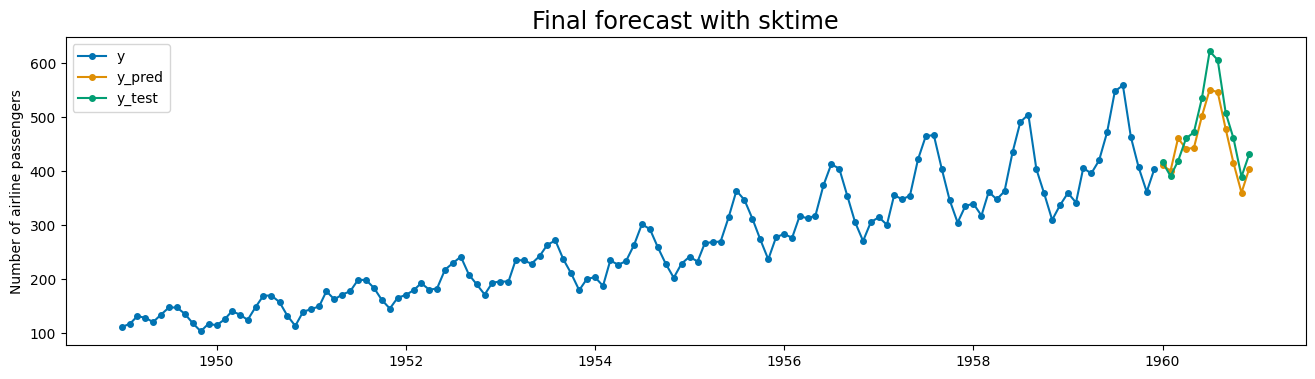

In [5]:
y = load_airline()
y_train, y_test = temporal_train_test_split(y, test_size=12)

log_transform = LogTransformer()
deseasonalize_transform = Deseasonalizer(sp=12)
forecast = AutoETS(sp=12)

forecaster_explicit = TransformedTargetForecaster(
    [
        ("log", log_transform),
        ("deseasonalize", deseasonalize_transform),
        ("forecast", forecast),
    ]
)

fh = range(1, 12 + 1)
y_pred = forecaster_explicit.fit_predict(y_train, fh=fh)

_ = plot_series(y_train, y_pred, y_test, labels=["y", "y_pred", "y_test"], title="Final forecast with sktime")

In [6]:
forecaster_explicit

TransformedTargetForecaster(steps=[('log', LogTransformer()),
                                   ('deseasonalize', Deseasonalizer(sp=12)),
                                   ('forecast', AutoETS(sp=12))])

##### Using the dunder magic: Implicit

The alternative way of creating pipelines is by using the overloaded operator `*` between transfromers and forecasters.

In [7]:
forecaster_dunder = log_transform * deseasonalize_transform * forecast

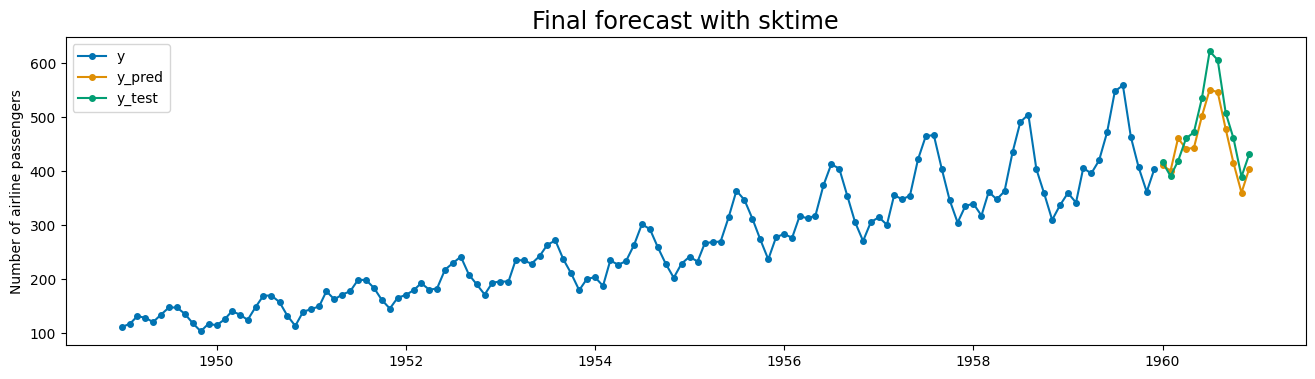

In [8]:
y_pred = forecaster_dunder.fit_predict(y_train, fh=fh)

_ = plot_series(y_train, y_pred, y_test, labels=["y", "y_pred", "y_test"], title="Final forecast with sktime")

In [9]:
forecaster_dunder

TransformedTargetForecaster(steps=[LogTransformer(), Deseasonalizer(sp=12),
                                   AutoETS(sp=12)])

### III.2. Reduction: Using `scikit-learn` regressors for forecasting


Reduction is a powerful pattern that allows you to use any `scikit-learn` regressor (e.g., `KNeighborsRegressor`, `RandomForestRegressor`) for time series forecasting. The forecasting problem is "reduced" to a regression problem by transforming the time series into a tabular format, typically using a sliding window approach where lagged values of the series become features and future values become the target.


`sktime`'s `make_reduction` function is a convenient way to create a forecaster from a `scikit-learn` regressor.

In [10]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [11]:
from sktime.datasets import load_airline
from sktime.forecasting.base import ForecastingHorizon
from sktime.forecasting.compose import make_reduction
from sktime.split import temporal_train_test_split
from sktime.utils.plotting import plot_series
from sktime.performance_metrics.forecasting import mean_absolute_percentage_error

In [12]:
from sklearn.neighbors import KNeighborsRegressor

In [13]:

# Data loading for illustration
y = load_airline()
y_train, y_test = temporal_train_test_split(y, test_size=36)
fh = ForecastingHorizon(y_test.index, is_relative=False)

# Create a forecaster from KNeighborsRegressor using "recursive" strategy
regressor = KNeighborsRegressor(n_neighbors=3)
forecaster_knn = make_reduction(
    regressor,
    window_length=15, # How many past lags to use as features
    strategy="recursive" # Predict one step, then use prediction as input for next step
)

forecaster_knn.fit(y_train)
y_pred_knn = forecaster_knn.predict(fh)

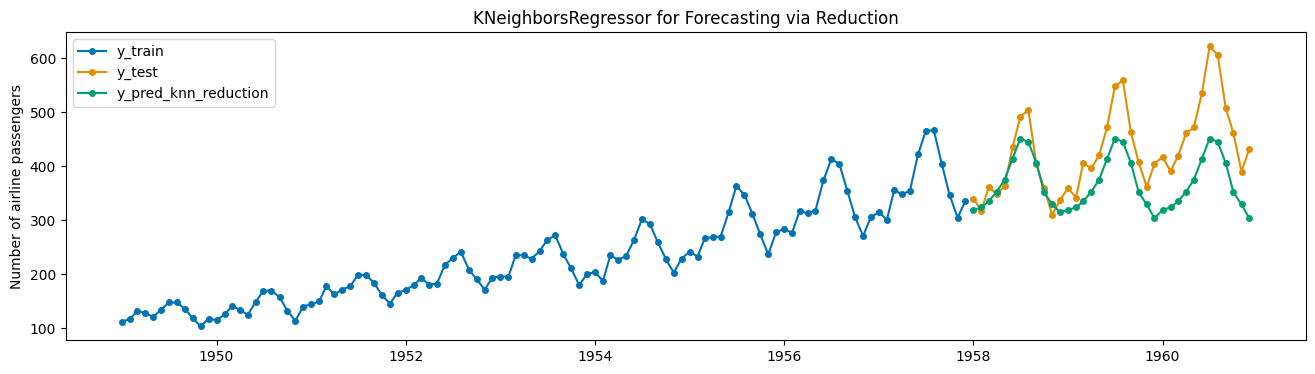

In [14]:
plot_series(y_train, y_test, y_pred_knn, labels=["y_train", "y_test", "y_pred_knn_reduction"])
plt.title("KNeighborsRegressor for Forecasting via Reduction")
plt.show()

In [15]:
mape_knn = mean_absolute_percentage_error(y_test, y_pred_knn, symmetric=False)
print(f"MAPE for KNN Reduction Forecaster: {mape_knn:.4f}")

MAPE for KNN Reduction Forecaster: 0.1377


In [16]:
# You can inspect the parameters, including those of the wrapped scikit-learn regressor
print("\nParameters of the reduction forecaster:")
print(forecaster_knn.get_params())


Parameters of the reduction forecaster:
{'estimator': KNeighborsRegressor(n_neighbors=3), 'pooling': 'local', 'transformers': None, 'window_length': 15, 'estimator__algorithm': 'auto', 'estimator__leaf_size': 30, 'estimator__metric': 'minkowski', 'estimator__metric_params': None, 'estimator__n_jobs': None, 'estimator__n_neighbors': 3, 'estimator__p': 2, 'estimator__weights': 'uniform'}


In [17]:
forecaster_knn

RecursiveTabularRegressionForecaster(estimator=KNeighborsRegressor(n_neighbors=3),
                                     window_length=15)

- Other reduction strategies include: `"direct"`, `"dirrec"`, and `"multioutput"`.
- Parameters of the underlying regressor can be accessed and tuned using `get_params()` and `set_params()`.

In [18]:
forecaster_knn.get_params()

{'estimator': KNeighborsRegressor(n_neighbors=3),
 'pooling': 'local',
 'transformers': None,
 'window_length': 15,
 'estimator__algorithm': 'auto',
 'estimator__leaf_size': 30,
 'estimator__metric': 'minkowski',
 'estimator__metric_params': None,
 'estimator__n_jobs': None,
 'estimator__n_neighbors': 3,
 'estimator__p': 2,
 'estimator__weights': 'uniform'}

#### Using sklearn models in sktime pipelines

`make_reduction` is compatible with pipelining, and that is a great advantage:

In [19]:
from sktime.forecasting.trend import PolynomialTrendForecaster
from sktime.transformations.series.detrend import Deseasonalizer, Detrender

0.05870838788931646

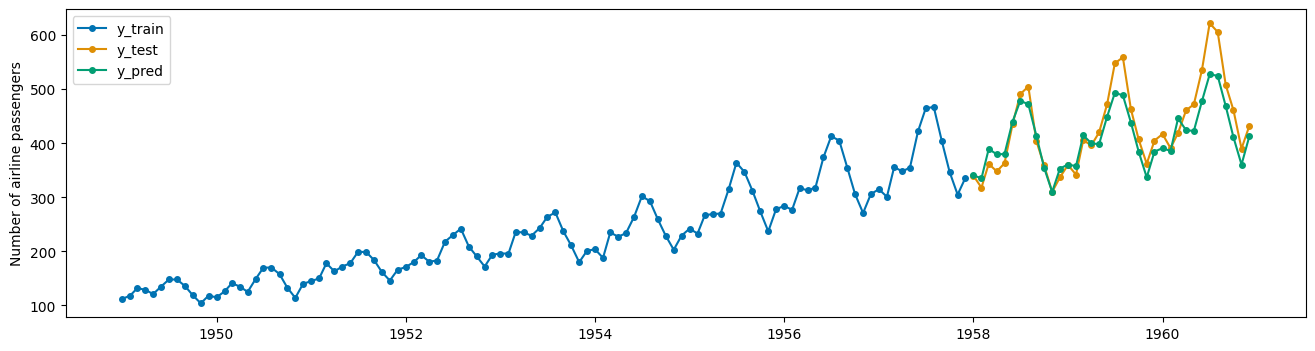

In [20]:
forecaster = TransformedTargetForecaster(
    [
        ("deseasonalize", Deseasonalizer(model="multiplicative", sp=12)),
        ("detrend", Detrender(forecaster=PolynomialTrendForecaster(degree=1))),
        (
            "forecast",
            make_reduction(
                KNeighborsRegressor(),
                window_length=15,
                strategy="recursive",
            ),
        ),
    ]
)

forecaster.fit(y_train)
y_pred = forecaster.predict(fh)
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])
mean_absolute_percentage_error(y_test, y_pred, symmetric=False)

### III.C. Tuning Forecaster Hyperparameters


`sktime` provides hyperparameter tuning strategies similar to scikit-learn's GridSearchCV, but adapted for time series data. 

`ForecastingGridSearchCV` is used with a forecaster, a temporal cross-validation strategy (like `SlidingWindowSplitter`), and a parameter grid.

In [21]:
from sktime.forecasting.model_selection import ForecastingGridSearchCV
from sktime.split import SlidingWindowSplitter
from sklearn.neighbors import KNeighborsRegressor
from sktime.forecasting.compose import make_reduction


Tuning hyperparameters with ForecastingGridSearchCV...
Best parameters found: {'estimator__n_neighbors': 1, 'window_length': 12}


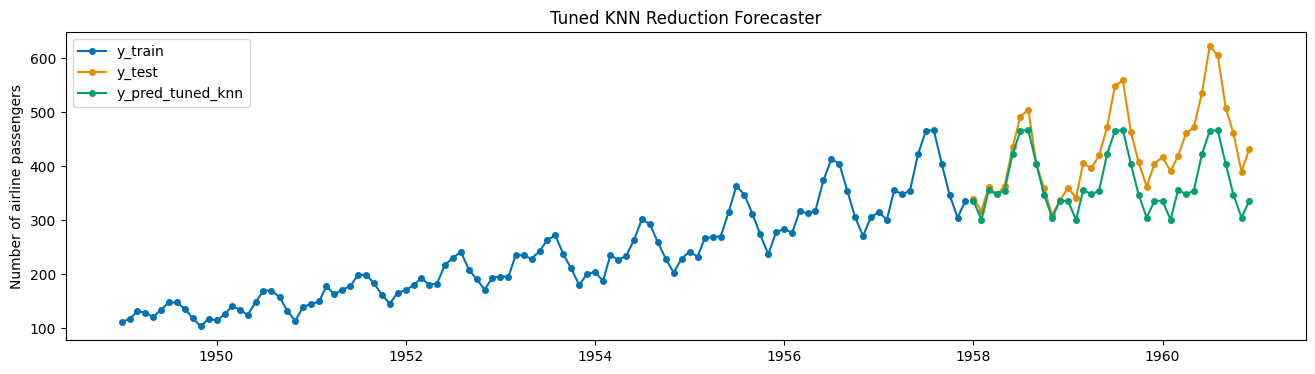

In [22]:
# Example: Tune window_length and n_neighbors for the KNN reduction forecaster
regressor_for_tuning = KNeighborsRegressor()
forecaster_to_tune = make_reduction(regressor_for_tuning, strategy="recursive")

param_grid = {
    "window_length": [12, 15, 18],
    "estimator__n_neighbors": [1, 3, 5] # Note the __ to access nested parameters
}

# Use a temporal cross-validation splitter
cv_splitter = SlidingWindowSplitter(initial_window=int(len(y_train) * 0.7), window_length=24, step_length=12)

gscv = ForecastingGridSearchCV(
    forecaster=forecaster_to_tune,
    strategy="refit", # Refit on full training data after finding best params
    cv=cv_splitter,
    param_grid=param_grid,
    # scoring=None # Defaults to MASE or uses forecaster's default if available
)

print("\nTuning hyperparameters with ForecastingGridSearchCV...")
gscv.fit(y_train)

print(f"Best parameters found: {gscv.best_params_}")

y_pred_tuned = gscv.predict(fh)

plot_series(y_train, y_test, y_pred_tuned, labels=["y_train", "y_test", "y_pred_tuned_knn"])
plt.title("Tuned KNN Reduction Forecaster")
plt.show()

In [23]:
mape_tuned = mean_absolute_percentage_error(y_test, y_pred_tuned, symmetric=False)
print(f"MAPE for Tuned KNN Forecaster: {mape_tuned:.4f}")

# Access the best forecaster instance
best_forecaster_instance = gscv.best_forecaster_

print("\nBest forecaster instance:")
best_forecaster_instance.get_params()

MAPE for Tuned KNN Forecaster: 0.1272

Best forecaster instance:


{'estimator': KNeighborsRegressor(n_neighbors=1),
 'pooling': 'local',
 'transformers': None,
 'window_length': 12,
 'estimator__algorithm': 'auto',
 'estimator__leaf_size': 30,
 'estimator__metric': 'minkowski',
 'estimator__metric_params': None,
 'estimator__n_jobs': None,
 'estimator__n_neighbors': 1,
 'estimator__p': 2,
 'estimator__weights': 'uniform'}

### III.4. AutoML: Automated Model and Pipeline Selection

**AutoML** in `sktime` takes automation a step further by selecting not just hyperparameters but entire forecasting strategies or pipeline structures.

The `MultiplexForecaster` is a key tool here. It allows you to define a list of candidate forecasters, and then use a tuner (like `ForecastingGridSearchCV`) to select the best one based on performance on cross-validation.

In [24]:
from sktime.forecasting.compose import MultiplexForecaster
from sktime.forecasting.exp_smoothing import ExponentialSmoothing
from sktime.forecasting.naive import NaiveForecaster
from sktime.forecasting.arima import AutoARIMA
from sktime.forecasting.theta import ThetaForecaster

In [25]:
# Define a list of candidate forecasters
candidate_forecasters = [
        ("naive", NaiveForecaster(strategy="last")),
        ("ets", ExponentialSmoothing(trend="add", sp=12)),
        ("auto_ets", AutoETS()),
        ("theta", ThetaForecaster(sp=12)),
]

multiplexer = MultiplexForecaster(forecasters=candidate_forecasters)

cv = SlidingWindowSplitter(window_length=12*4, fh=12)

# The 'selected_forecaster' parameter of MultiplexForecaster is tuned.
forecaster_param_grid = {"selected_forecaster": ["naive", "ets", "auto_ets", "theta"]}

# Use ForecastingGridSearchCV to find the best forecaster
# Using the same cv_splitter from the tuning example
auto_ml_forecaster = ForecastingGridSearchCV(multiplexer, cv=cv, param_grid=forecaster_param_grid)

# AutoML
auto_ml_forecaster.fit(y_train)

ForecastingGridSearchCV(cv=SlidingWindowSplitter(fh=12, window_length=48),
                        forecaster=MultiplexForecaster(forecasters=[('naive',
                                                                     NaiveForecaster()),
                                                                    ('ets',
                                                                     ExponentialSmoothing(sp=12,
                                                                                          trend='add')),
                                                                    ('auto_ets',
                                                                     AutoETS()),
                                                                    ('theta',
                                                                     ThetaForecaster(sp=12))]),
                        param_grid={'selected_forecaster': ['naive', 'ets',
                                                            'auto_ets',
                                                            'theta']})

In [26]:
print(f"Best forecaster selected by AutoML: {auto_ml_forecaster.best_params_['selected_forecaster']}")

Best forecaster selected by AutoML: ets


In [27]:
y_pred_automl = auto_ml_forecaster.predict(fh)

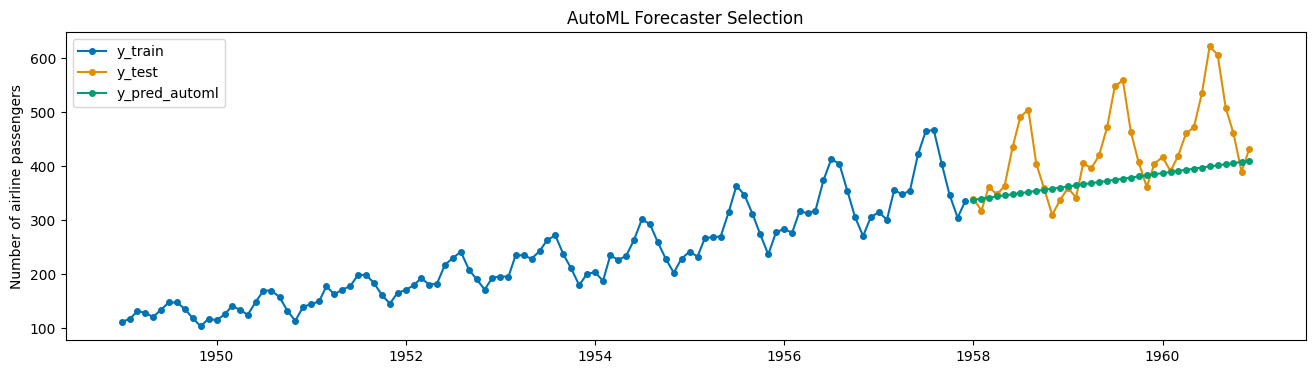

MAPE for AutoML selected Forecaster: 0.1309


In [28]:
plot_series(y_train, y_test, y_pred_automl, labels=["y_train", "y_test", "y_pred_automl"])
plt.title("AutoML Forecaster Selection")
plt.show()
mape_automl = mean_absolute_percentage_error(y_test, y_pred_automl, symmetric=False)
print(f"MAPE for AutoML selected Forecaster: {mape_automl:.4f}")